In [112]:
%matplotlib inline
from os import listdir
from os.path import join, dirname, realpath, isdir, getmtime
from glob import glob

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

from IPython.core.interactiveshell import InteractiveShell

# Notebook config
InteractiveShell.ast_node_interactivity = "all"

# directories
BASE_DIR = dirname(realpath("__file__"))
RESULTS_DIR = join(BASE_DIR, 'results')
LATEST_DIR = max([join(RESULTS_DIR, d) for d in listdir(RESULTS_DIR)
                  if isdir(join(RESULTS_DIR, d))], key=getmtime)

# globals
CSV_NAMES = ["ip_proto", "epoch",
             "ip_src", "ip_dst", "port_src", "port_dst",
             "ip_len", "ip_hdr_len", "tcp_hdr_len", "data_len",
             "tcp_flags", "tcp_seq", "tcp_ack",
             "tcp_window_size_value", "ws_message",
             "tcp_options_tsval", "tcp_options_tsecr"]

In [113]:
# get filenames
stat_files = {}
for fname in listdir(LATEST_DIR):
    if fname not in stat_files:
        key = fname.split('_')[0]
        stat_files[key] = glob(join(LATEST_DIR, key + '*'))

print "Found stats for %s guards" % len(stat_files)
print "In average, entries have %s samples" % np.mean([len(l) for l in stat_files.itervalues()])
    

Found stats for 8 guards
In average, entries have 1.0 samples


In [114]:
# load data in a dataframe
dfs = []
for k, l in stat_files.iteritems():
    for i, fpath in enumerate(l):
        df = pd.read_csv(fpath, names=CSV_NAMES)
        df = df[(df['tcp_flags'] == '0x0002') | (df['tcp_flags'] == '0x0012')]  # SYN and SYN,ACK packets
        df['entry'] = k
        df['sample'] = i
        dfs.append(df)
data = pd.concat(dfs)

In [115]:
def latencies(data):
    """Compute latencies for all samples in the dataframe."""
    return data.groupby(['entry', 'sample']).apply(lambda d: np.diff(d['epoch'])[0]).reset_index(name='latency')

def jitter(latencies):
    """Compute jitter for latency data."""
    return latencies['latency']

Latency dataset:


,entry,sample,latency
0,00161E152FCF43380176F13B964656BD243D6F33,0,0.027267
1,00459AF0E9DED00E54A48B268126679F578F695A,0,0.029477
2,0063D0DE32C80691A0AC1A968A8CCF5ABA420E29,0,0.169964
3,006C0B92328C89043ECCD5F031D8A333A2783598,0,0.034774
4,007900928C7D38CFDCB3BC8407CAD6EE57A24FE2,0,0.033986


Latency statistics. The latency std is the network jitter.


,sample,latency
count,5.0,5.000000
mean,0.0,0.059094
std,0.0,0.062057
min,0.0,0.027267
25%,0.0,0.029477
50%,0.0,0.033986
75%,0.0,0.034774
max,0.0,0.169964


Histogram for latencies


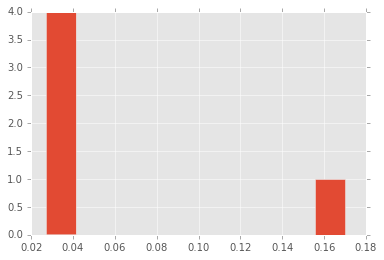

In [116]:
print "Latency dataset:"
latencies(data).head()

print "Latency statistics. The latency std is the network jitter."
latencies(data).describe()

print "Histogram for latencies"
latencies(data)['latency'].hist()